In [1]:
import sys
sys.path.append('/usr/local/lib/python2.7/site-packages')

import os
import cv2
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.core import Activation, Dropout, Flatten, Dense, Lambda
from keras.layers import ELU
from keras.optimizers import Adam
import keras.backend.tensorflow_backend as KTF

import warnings
warnings.filterwarnings('ignore')


N_img_height = 66
N_img_width = 220
N_img_channels = 3
def nvidia_model():
    inputShape = (N_img_height, N_img_width, N_img_channels)

    model = Sequential()
    # normalization    
    # perform custom normalization before lambda layer in network
    model.add(Lambda(lambda x: x/ 127.5 - 1, input_shape = inputShape))

    model.add(Convolution2D(24, (5, 5), 
                            strides=(2,2), 
                            padding = 'valid',
                            kernel_initializer = 'he_normal',
                            name = 'conv1'))
    
    
    model.add(ELU())    
    model.add(Convolution2D(36, (5, 5), 
                            strides=(2,2), 
                            padding = 'valid',
                            kernel_initializer = 'he_normal',
                            name = 'conv2'))
    
    model.add(ELU())    
    model.add(Convolution2D(48, (5, 5), 
                            strides=(2,2), 
                            padding = 'valid',
                            kernel_initializer = 'he_normal',
                            name = 'conv3'))
    model.add(ELU())
    model.add(Dropout(0.5))
    model.add(Convolution2D(64, (3, 3), 
                            strides = (1,1), 
                            padding = 'valid',
                            kernel_initializer = 'he_normal',
                            name = 'conv4'))
    
    model.add(ELU())              
    model.add(Convolution2D(64, (3, 3), 
                            strides= (1,1), 
                            padding = 'valid',
                            kernel_initializer = 'he_normal',
                            name = 'conv5'))
              
              
    model.add(Flatten(name = 'flatten'))
    model.add(ELU())
    model.add(Dense(100, kernel_initializer = 'he_normal', name = 'fc1'))
    model.add(ELU())
    model.add(Dense(50, kernel_initializer = 'he_normal', name = 'fc2'))
    model.add(ELU())
    model.add(Dense(10, kernel_initializer = 'he_normal', name = 'fc3'))
    model.add(ELU())
    
    # do not put activation at the end because we want to exact output, not a class identifier
    model.add(Dense(1, name = 'output', kernel_initializer = 'he_normal'))
    
    adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.compile(optimizer = adam, loss = 'mse')

    return model

Using TensorFlow backend.


In [2]:
model = nvidia_model()
model.load_weights('/srv/beegfs02/scratch/aegis_guardian/data/speed_prediction/deeps/finetuned_64batch.h5')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


2022-04-06 12:53:36.106945: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-06 12:53:36.149630: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 3492230000 Hz
2022-04-06 12:53:36.150456: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5647f1121dd0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-04-06 12:53:36.150501: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
OMP: Info #155: KMP_AFFINITY: Initial OS proc set respected: 0-7
OMP: Info #216: KMP_AFFINITY: decoding x2APIC ids.
OMP: Info #157: KMP_AFFINITY: 8 available OS procs
OMP: Info #158: KMP_AFFINITY: Uniform topology
OMP: Info 

In [3]:
def opticalFlowOverlay(image_current, image_next):
    """
    input: image_currentdef preprocess_image_from_path(image_path, scale_factor=0.5, bright_factor=1):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = change_brightness(img, bright_factor)
    img = crop_image(img, scale_factor)
    return img, image_next (RGB images)
    output: mask
    """
    feature_params = dict( maxCorners = 500,
                       qualityLevel = 0.1,
                       minDistance = 7,
                       blockSize = 5 )
    lk_params = dict( winSize  = (15, 15),
                  maxLevel = 2,
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))
    
    image_current_saved = np.copy(image_current)
    image_next_saved = np.copy(image_next)
    
    image_current = cv2.cvtColor(image_current, cv2.COLOR_RGB2GRAY)
    image_next = cv2.cvtColor(image_next, cv2.COLOR_RGB2GRAY)
    
    # Finds edges in an image using the [Canny86] algorithm.
    p0 = cv2.goodFeaturesToTrack(image_current, mask = None, **feature_params)

    p1, st, err = cv2.calcOpticalFlowPyrLK(image_current, image_next, p0, None, **lk_params)


    color = np.random.randint(0, 255, (100, 3))

    mask = np.zeros_like(image_current)

    # Select good points
    good_new = p1[st == 1]
    good_old = p0[st == 1]
    for i, (new, old) in enumerate(zip(good_new, good_old)):
        a, b = new.ravel() # flatten
        c, d = old.ravel()
        mask = cv2.arrowedLine(mask, (a,b), (c, d), color[i%100].tolist(), 2, 8)
        
        image_next = cv2.circle(image_next_saved, (a, b), 1, color[i%100].tolist(), -1)
        image_next_fg = cv2.bitwise_and(image_next, image_next, mask = mask)
        
    dst = cv2.add(image_next, image_next_fg)
    return dst

In [4]:
def crop_image(image, scale):
    """
    preprocesses the image
    
    input: image (480 (y), 640 (x), 3) RGB
    output: image (shape is (66, 220, 3) as RGB)
    
    This stuff is performed on my validation data and my training data
    Process: 
             1) Cropping out black spots
             3) resize to (66, 220, 3) if not done so already from perspective transform
    """
    # Crop out sky (top 130px) and the hood of the car (bottom 270px) 
    image_cropped = image[130:370,:] # -> (240, 640, 3)
    
    height = int(240*scale)
    width = int(640*scale)
    image = cv2.resize(image_cropped, (220, 66), interpolation = cv2.INTER_AREA)
    
    return image

In [5]:
def opticalFlowDense(image_current, image_next):
    """
    input: image_current, image_next (RGB images)
    calculates optical flow magnitude and angle and places it into HSV image
    * Set the saturation to the saturation value of image_next
    * Set the hue to the angles returned from computing the flow params
    * set the value to the magnitude returned from computing the flow params
    * Convert from HSV to RGB and return RGB image with same size as original image
    """
    gray_current = cv2.cvtColor(image_current, cv2.COLOR_RGB2GRAY)
    gray_next = cv2.cvtColor(image_next, cv2.COLOR_RGB2GRAY)
    
    hsv = np.zeros(image_current.shape)
    # set saturation
    hsv[:,:,1] = cv2.cvtColor(image_next, cv2.COLOR_RGB2HSV)[:,:,1]
 
    # Flow Parameters
    flow_mat = None
    image_scale = 0.5
    nb_images = 1
    win_size = 15
    nb_iterations = 2
    deg_expansion = 5
    STD = 1.3
    extra = 0

    # obtain dense optical flow paramters
    flow = cv2.calcOpticalFlowFarneback(gray_current, gray_next,  
                                        flow_mat, 
                                        image_scale, 
                                        nb_images, 
                                        win_size, 
                                        nb_iterations, 
                                        deg_expansion, 
                                        STD, 
                                        0)
                                        
        
    # convert from cartesian to polar
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])  
        
    # hue corresponds to direction
    hsv[:,:,0] = ang * (180/ np.pi / 2)
    
    # value corresponds to magnitude
    hsv[:,:,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
    
    # convert HSV to float32's
    hsv = np.asarray(hsv, dtype= np.float32)    

    rgb_flow = cv2.cvtColor(hsv,cv2.COLOR_HSV2RGB)

    
    return rgb_flow

In [6]:
def preprocess_image_from_path(image_path, scale_factor=0.5, bright_factor=1):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = crop_image(img, scale_factor)
    return img

In [38]:
ls data

driving.csv      predict.csv      test_frames/     train.txt
predict/         test.mp4         train.mp4        training_frames/


In [7]:
def capture_frames(video_source, speed_data):
    
    '''
    Captures .mp4 video frames to .jpg images and creates a .csv to store the capture information
    '''
    
    num_frames = speed_data.shape[0]
    
    # create VideoCapture instance
    cap = cv2.VideoCapture(video_source)
    # set frame count
    cap.set(cv2.CAP_PROP_FRAME_COUNT, num_frames)
    
    with open('./data/predict.csv', 'w') as csvfile:
        fieldnames = ['image_path', 'frame', 'speed']
        writer = csv.DictWriter(csvfile, fieldnames = fieldnames)
        writer.writeheader()

        for idx in xrange(num_frames):
            # set frame index
            cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
            # read the frame
            success, image = cap.read()

            if success:
                image_path = os.path.join('./data/test_frames/', str(idx) + '.jpg')

                # save image to IMG folder
                cv2.imwrite(image_path, image)

                # write row to driving.csv
                writer.writerow({'image_path': image_path,
                         'frame': idx,
                         'speed': speed_data[idx],
                        })
            else:
                print ('Failed to read frame '), idx
        
        print ('Done!')

In [8]:
data = pd.read_csv('/srv/beegfs02/scratch/aegis_guardian/data/speed_prediction/deeps/sanity_check.csv', header=None)
data.columns = ['image_path', 'time', 'speed']

In [9]:
data.head()

,image_path,time,speed
0,/srv/beegfs02/scratch/aegis_guardian/data/spee...,0.083333,0.499493
1,/srv/beegfs02/scratch/aegis_guardian/data/spee...,0.083333,0.499493
2,/srv/beegfs02/scratch/aegis_guardian/data/spee...,0.083333,0.499493
3,/srv/beegfs02/scratch/aegis_guardian/data/spee...,0.083333,0.499493
4,/srv/beegfs02/scratch/aegis_guardian/data/spee...,0.083333,0.499493


In [10]:
len(data.index)

5000

In [12]:
pred = []
err = []
for i in range(len(data)-1):
    y1 = data.iloc[i]['speed']
    y2 = data.iloc[i+1]['speed']
    
    x1 = preprocess_image_from_path(data.iloc[i]['image_path'])
    x2 = preprocess_image_from_path(data.iloc[i+1]['image_path'])
    
    img1 = cv2.cvtColor(cv2.imread(data.iloc[i]['image_path']), cv2.COLOR_BGR2RGB)
    img2 = cv2.cvtColor(cv2.imread(data.iloc[i+1]['image_path']), cv2.COLOR_BGR2RGB)
        
    rgb_diff = opticalFlowDense(x1, x2)
    rgb_diff = rgb_diff.reshape(1, rgb_diff.shape[0], rgb_diff.shape[1], rgb_diff.shape[2])
    avg_speed = np.array([[np.mean([y1,y2])]])
    
    prediction = model.predict(rgb_diff)
    pred.append(prediction)
    error = abs(prediction - y2)
    err.append(error)
    truth = y2
    
    print(f'Truth: {avg_speed}, Prediction: {prediction} with an error of {error}')
    
    predict_path = os.path.join('./data/predict/', str(i) + '.jpg')
    # print(f'Truth: {y2}, Prediction: {prediction} with an error of {error}')
    
    # dst = np.copy(img2)
    
    # dst = opticalFlowOverlay(img1, img2) # This is a sparse optical flow overlay
    
    # # to write new image via openCV
    # offset = 50
    # FONT_SIZE = 1
    # THICKNESS = 2
    # font = cv2.FONT_HERSHEY_SIMPLEX
    # cv2.putText(dst,'pred: ' + str(prediction[0][0])[:5],(10,offset), font, FONT_SIZE,(255,250,40), THICKNESS,cv2.LINE_AA)
    # cv2.putText(dst,'truth: ' + str(y2)[:5],(10,offset+50), font, FONT_SIZE,(35,255,70), THICKNESS,cv2.LINE_AA)
    # cv2.putText(dst, 'error: ' + str(error[0][0])[:5], (10, offset+100),font, FONT_SIZE, (255, 120, 80), THICKNESS, cv2.LINE_AA)
    
    # # convert back to BGR for writing
    # dst = cv2.cvtColor(dst, cv2.COLOR_RGB2BGR)
    # cv2.imwrite(predict_path, dst)
    
print('done!')
    

Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.8

Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.8

Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.8

Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.8

Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.8

Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.8

Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.8

Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.8

Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.8

Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.8

Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.8

Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.8

Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.8

Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.8

Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.8

Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.8

Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.8

Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.8

Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.8

Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.8

Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.8

Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.8

Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.8

Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.8

Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.8

Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.8

Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.8

Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.8

Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.8

Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.8

Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.8

Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.8

Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.8

Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.8

Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.8

Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.8

Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.8

Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.8

Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.8

Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.8

Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.8

Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.8

Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.8

Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.8

Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.8

Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.8

Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.8

Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.8

Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.875508]] with an error of [[0.37601462]]
Truth: [[0.49949338]], Prediction: [[0.8

In [16]:
import numpy as np
predict = []
mse = []
for i in range(len(pred)):
    predict.append(pred[i][0][0])
    mse.append(err[i][0][0])

In [17]:
sum(mse)

6597.930102109909

In [19]:
predict

[0.18727149,
 0.13240667,
 0.18727149,
 0.13240667,
 0.18727149,
 0.13240667,
 0.18727149,
 0.13240667,
 0.18727149,
 0.13240667,
 0.18727149,
 0.13240667,
 0.18727149,
 0.13240667,
 0.18727149,
 0.13240667,
 0.18727149,
 0.13240667,
 0.18727149,
 0.13240667,
 0.18727149,
 0.13240667,
 0.18727149,
 0.13240667,
 0.18727149,
 0.13240667,
 0.18727149,
 0.13240667,
 0.18727149,
 0.13240667,
 0.18727149,
 0.13240667,
 0.18727149,
 0.13240667,
 0.18727149,
 0.13240667,
 0.18727149,
 0.13240667,
 0.18727149,
 0.13240667,
 0.18727149,
 0.13240667,
 0.18727149,
 0.13240667,
 0.18727149,
 0.13240667,
 0.18727149,
 0.13240667,
 0.18727149,
 0.13240667,
 0.18727149,
 0.13240667,
 0.18727149,
 0.13240667,
 0.18727149,
 0.13240667,
 0.18727149,
 0.13240667,
 0.18727149,
 0.13240667,
 0.18727149,
 0.13240667,
 0.18727149,
 0.13240667,
 0.18727149,
 0.13240667,
 0.18727149,
 0.13240667,
 0.18727149,
 0.13240667,
 0.18727149,
 0.13240667,
 0.18727149,
 0.13240667,
 0.18727149,
 0.13240667,
 0.18727149,

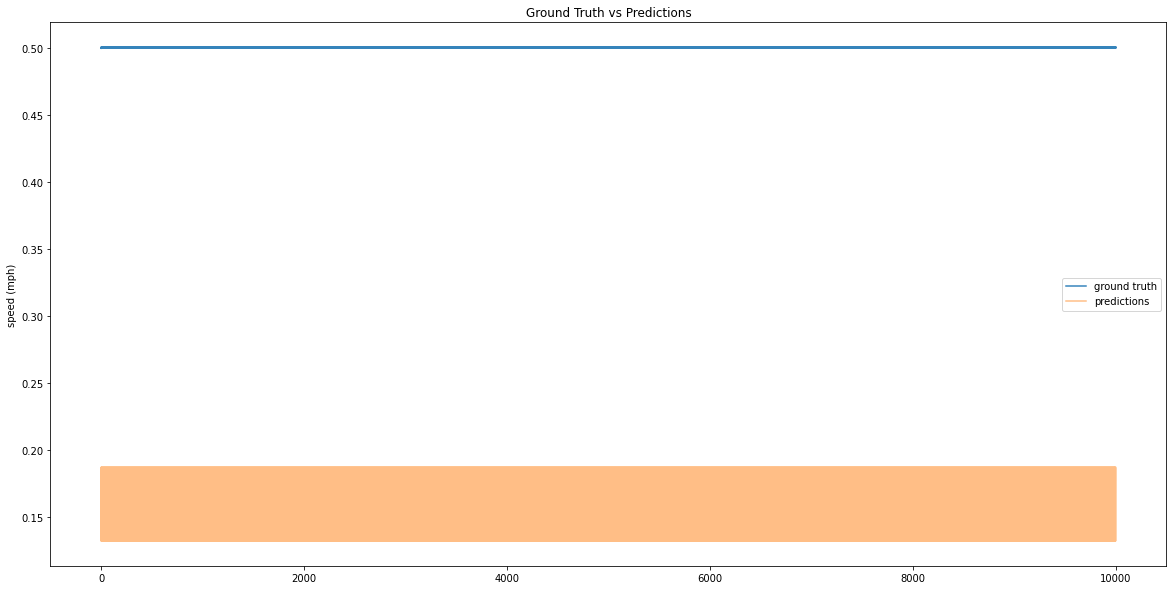

In [25]:
import matplotlib.pyplot as plt
plt.figure(1, figsize=(20,10))

plt.plot(data['speed'], alpha=0.9, )
plt.plot(predict, alpha=0.5)
plt.ylabel('speed (mph)')
plt.title('Ground Truth vs Predictions')
plt.legend(['ground truth', 'predictions'])

In [ ]:
from moviepy.editor import VideoFileClip
from moviepy.editor import ImageSequenceClip
import glob
import os

images = ['./data/predict/' + str(i+1) + '.jpg' for i in range(0, 20398)]
clip = ImageSequenceClip(images, fps=60)
clip.write_videofile("predicted_speed_fast.mp4", fps=60)
print('done!')